In [1]:
import math
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt

cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

if 'aigents_api' in sys.modules:
    del sys.modules['aigents_api']
if 'learn' in sys.modules:
    del sys.modules['learn']
if 'util' in sys.modules:
    del sys.modules['util']

from pygents.learn import count_ngrams_plus, count_ngrams_plus_tf_idf
from pygents.aigents_api import TextMetrics

model_family = 'binary_view_cleaned'
if not os.path.exists('data/models/distortions/split_babacan_multiclass/'+model_family+'/'):
    os.makedirs('data/models/distortions/split_babacan_multiclass/'+model_family+'/')
for split_name in ['first_split','second_split','third_split']:
    split_path = 'data/models/distortions/split_babacan_multiclass/'+model_family+'/'+split_name+'/'
    if not os.path.exists(split_path):
        os.makedirs(split_path)
    
grand_t0 = dt.datetime.now()

def language_metrics(metrics_list, name_split_folder):
    metrics = {}
    for m in metrics_list:
        metrics[m] = f'data/models/distortions/split_babacan_multiclass/{model_family}/{name_split_folder}/{m}.txt'
    return metrics

In [2]:
from datasets import load_dataset

ds = load_dataset(
    "halilbabacan/combined_synthetic_cognitive_distortions",
    split="train",
)

df = ds.to_pandas()
df = df.rename(columns={'text': 'Patient Question', 'label': 'Dominant Distortion'})
df.insert(1, 'Distorted part', value = np.nan)
df.insert(3, 'Secondary Distortion (Optional)', value = np.nan)
# Remove the row with index 738 because it contains a NaN in the text column
df = df.drop(index=738)


mapping = {
    "Labelling":            "Labeling",
    "Mental Filter":        "Mental filter",
    "Should Statements":    "Should statements",
    "All-or-Nothing Thinking": "All-or-nothing thinking"
}

df['Dominant Distortion'] = df['Dominant Distortion'].map(mapping).fillna(df['Dominant Distortion'])

df

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,John walked past me without saying a word He m...,NaN,Mind Reading,NaN
1,"During the meeting, Sarah didn't look at me on...",NaN,Mind Reading,NaN
2,Mike didn't respond to my text right away He m...,NaN,Mind Reading,NaN
3,Jessica didn't smile when she saw me She must ...,NaN,Mind Reading,NaN
4,Tom didn't invite me to his party He must not ...,NaN,Mind Reading,NaN
...,...,...,...,...
4526,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
4527,Now I am at university my peers around me all ...,NaN,Overgeneralization,NaN
4528,He claims he’s severely depressed and has outb...,NaN,Mental filter,NaN
4529,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


# Create training functions
### Functions for including key N-grams and creating model files

In [3]:
def ngrams_inclusion(model_ngram, ngram_inclusion_threshold):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (ngram_inclusion_threshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram


def create_model_files(filtered_model_ngram, name_split_folder):
    # Create .txt files for each distortion
    output_dir = f'data/models/distortions/split_babacan_multiclass/{model_family}/{name_split_folder}'
    distortions_labels = []

    for distortion, ngrams in filtered_model_ngram.items():
        distortion_ = distortion.replace(" ", "_")
        file_path = f"{output_dir}/{distortion_}.txt"
        sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True) 
        distortions_labels.append(distortion)
        with open(file_path, "w", encoding="utf-8") as f:
            for ngram, metric_value in sorted_ngrams: 
                f.write(f"{' '.join(ngram)}\t{metric_value}\n")

    return (list(set(distortions_labels) - {'No Distortion'}))

### Evaluate functions

In [4]:
def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold, tm, debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold, tm)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,tm, debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative)

def evaluate_df_acc_f1(df,evaluator,threshold,tm,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    if metrics.get('Distortion', 0) > threshold:
        return True
    return False

### Functions for analyzing the dataset and plot heatmaps

In [5]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title=None, subtitle=None, vmin=None, vmax=None, dpi=None, titlefontsize=None, subtitlefontsize=None, width=20):
    plt.rcParams["figure.figsize"] = (width, len(row_labels) / 4)
    if dpi is not None:
        plt.rcParams["figure.dpi"] = dpi

    fig, ax = plt.subplots()

    p = sns.heatmap(matrix, ax=ax, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin=-absmax if vmin is None else vmin, 
                    vmax=absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        ax.set_title(title, fontsize=titlefontsize, pad=20)

    if subtitle is not None:
        if subtitlefontsize is None:
            subtitlefontsize = round(titlefontsize * 0.7)
        ax.text(0.5, 1.01, subtitle, fontsize=subtitlefontsize, ha='center', va='bottom', transform=ax.transAxes)

    plt.show()    


def analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, df_train, df_test, name_split_folder, print_or_plot):
    
    if name_split_folder == 'first_split' and print_or_plot == 'print_results':
        print('\nN-gram selection metric:', ngram_selection_metric)
        print('N-gram max length:', ngram_max)
        print('N-gram inclusion threshold:', ngram_inclusion_threshold)

    if ngram_selection_metric == 'TF-IDF':
        model_ngram = count_ngrams_plus_tf_idf(df_train,ngram_max,binary=True, clean_punct=True)
    
    elif ngram_selection_metric in ['F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','FN*UFN*UF/D/D','CFR','FCR','MR','NLMI']:
        distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
        norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
        norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df_train,ngram_max,binary=True, clean_punct=True)
        
        selection_metrics = {
            'F':frequency,
            'UF':unique_frequency,
            'FN':frequency_self_normalized,
            'UFN':unique_frequency_self_normalized,
            'UFN/D/D':norm_uniq_n_gram_dicts,
            'FN*UFN':norm_norm_uniq,
            'FN*UFN/D':norm_norm_uniq_norm,
            'CFR':cfr,
            'FCR':fcr,
            'MR':mr,
            'NLMI':nl_mi}
        
        model_ngram = selection_metrics[ngram_selection_metric]

    # Filter out values below the threshold
    filtered_model_ngram = ngrams_inclusion(model_ngram, ngram_inclusion_threshold)

    # Create .txt files for each distortion
    distortions_labels = create_model_files(filtered_model_ngram, name_split_folder)
    tm = TextMetrics(language_metrics(distortions_labels, name_split_folder), encoding = "utf-8", debug=False)

    if print_or_plot == 'print_results':
        if name_split_folder == 'first_split':
            print('\tFIRST COMBINATION')
        elif name_split_folder == 'second_split':
            print('\n\tSECOND COMBINATION')
        elif name_split_folder == 'third_split':
            print('\n\tTHIRD COMBINATION')

    if print_or_plot == 'print_results':
        print('\t\tThreshold, accuracy, F1 score:')
    any_res_acc = {}
    any_res = {}
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator,threshold, tm)
        any_res_acc[threshold] = acc
        any_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t\t', threshold, acc, f1)

    return any_res_acc


# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [6]:
def grid_search(df):
    part1 = df[df.index % 3 == 1]
    part2 = df[df.index % 3 == 2]
    part3 = df[df.index % 3 == 0]

    splits = [
        (pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
        (pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
        (pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
    ]

    for ngram_selection_metric in ['TF-IDF','F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','CFR','FCR','MR','NLMI']:
        for ngram_max in range (1, 5):
            for ngram_inclusion_threshold in [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]:
                for i, (train_df, test_df) in enumerate(splits, start=1):
                    if i == 1:
                        first_split_acc_any = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'print_results')
                    elif i == 2:
                        second_split_acc_any = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'print_results')
                    elif i == 3:
                        third_split_acc_any = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'print_results')
                                
                all_values = list(first_split_acc_any.values()) + list(second_split_acc_any.values()) + list(third_split_acc_any.values())

                min_value = min(all_values)
                max_value = max(all_values)
                mean_value = np.mean(all_values)

                print(f"\tMin accuracy: {min_value}\tMax accuracy: {max_value}\tMean accuracy: {mean_value}")


In [7]:
grid_search(df)


N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5874172185430464 0.7390029325513197
		 0.2 0.590066225165563 0.7400251994960101
		 0.3 0.5913907284768212 0.7337073802330599
		 0.4 0.5688741721854305 0.6847457627118644
		 0.5 0.4423841059602649 0.46437659033078876
		 0.6 0.2774834437086093 0.15229215229215232
		 0.7 0.2152317880794702 0.006705783738474434
		 0.8 0.21258278145695364 0
		 0.9 0.21258278145695364 0

	SECOND COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.5973509933774834 0.7472984206151289
		 0.2 0.6013245033112583 0.7483277591973243
		 0.3 0.5894039735099338 0.7339055793991416
		 0.4 0.5596026490066225 0.6792088760250844
		 0.5 0.41788079470198675 0.428106701366298
		 0.6 0.2596026490066225 0.1169036334913112
		 0.7 0.2119205298013245 0.0033500837520938024
		 0.8 0.21059602649006623 0
		 0.9 0.21059602649006623 0

	THIRD COMBINATION
		Threshold, accuracy, F1 score:
		 0

### Our best model obtained through the optimal combination of hyper-parameters

In [7]:
# Best model
part1 = df[df.index % 3 == 1]
part2 = df[df.index % 3 == 2]
part3 = df[df.index % 3 == 0]

splits = [
    (pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
    (pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
    (pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
]

for i, (train_df, test_df) in enumerate(splits, start=1):
    if i == 1:
        first_split_acc_any = analyse_dataset('FN*UFN', 1, 20, train_df, test_df, 'first_split', 'print_results')
    elif i == 2:
        second_split_acc_any = analyse_dataset('FN*UFN', 1, 20, train_df, test_df, 'second_split', 'print_results')
    elif i == 3:
        third_split_acc_any = analyse_dataset('FN*UFN', 1, 20, train_df, test_df, 'third_split', 'print_results')
                        


N-gram selection metric: FN*UFN
N-gram max length: 1
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7874172185430464 0.8810670618747685
		 0.2 0.7874172185430464 0.8810670618747685
		 0.3 0.7874172185430464 0.8810670618747685
		 0.4 0.7874172185430464 0.8810670618747685
		 0.5 0.7874172185430464 0.8810670618747685
		 0.6 0.7880794701986755 0.881305637982196
		 0.7 0.7966887417218543 0.8851477740366629
		 0.8 0.8695364238410596 0.9191629052113254
		 0.9 0.7086092715231788 0.7734294541709578

	SECOND COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7894039735099337 0.8823094004441155
		 0.2 0.7894039735099337 0.8823094004441155
		 0.3 0.7894039735099337 0.8823094004441155
		 0.4 0.7894039735099337 0.8823094004441155
		 0.5 0.7894039735099337 0.8823094004441155
		 0.6 0.7880794701986755 0.8814814814814815
		 0.7 0.7973509933774835 0.8852213053263316
		 0.8 0.8523178807947019 0.909312728751525
		 0.9 0.7245033112582782 0.7890466531440162



# Plot heatmaps 
## Plot heatmaps illustrating the search for optimal hyperparameters

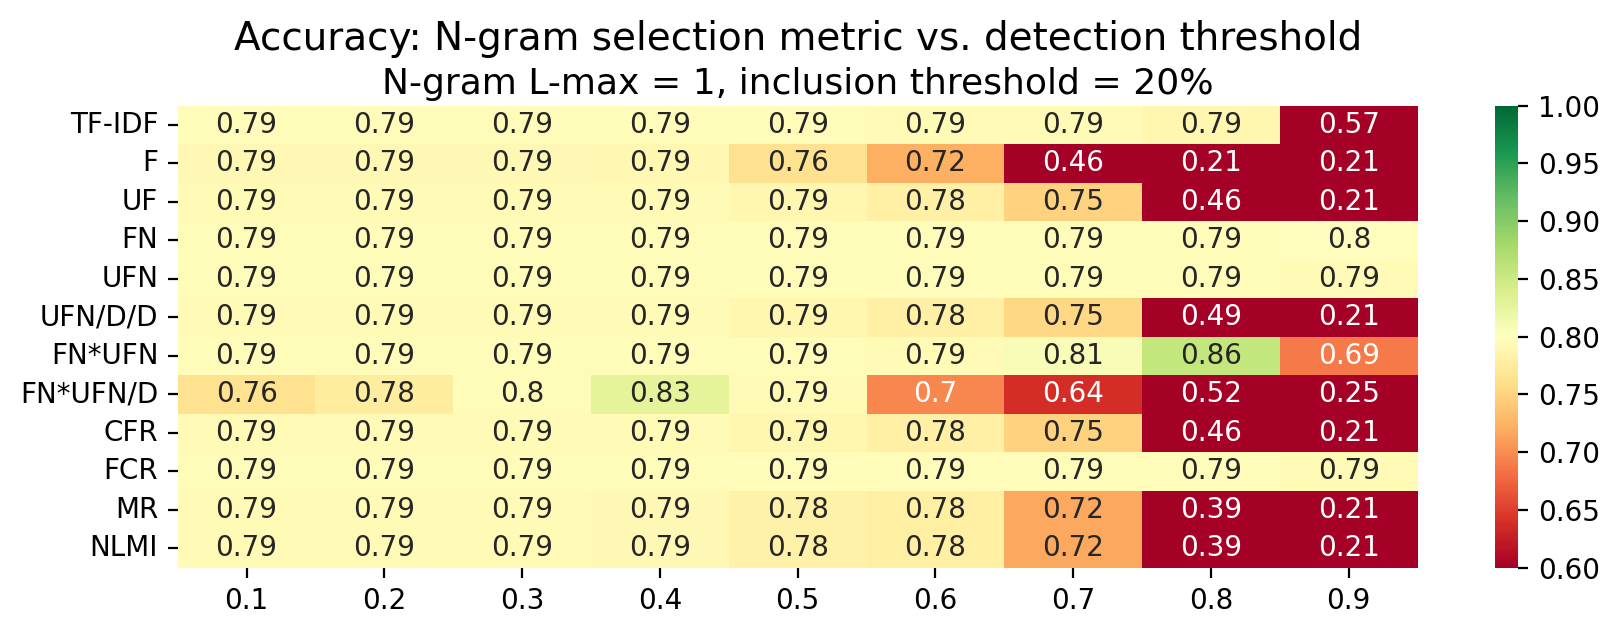

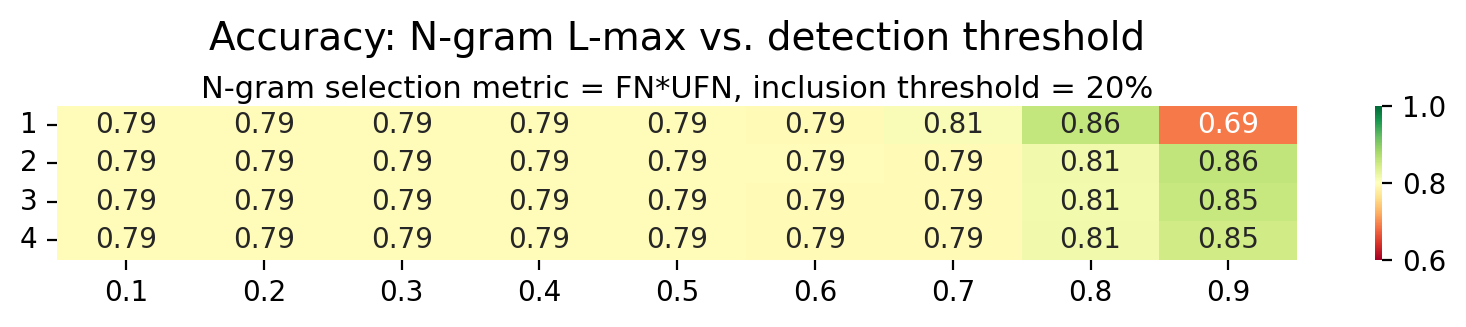

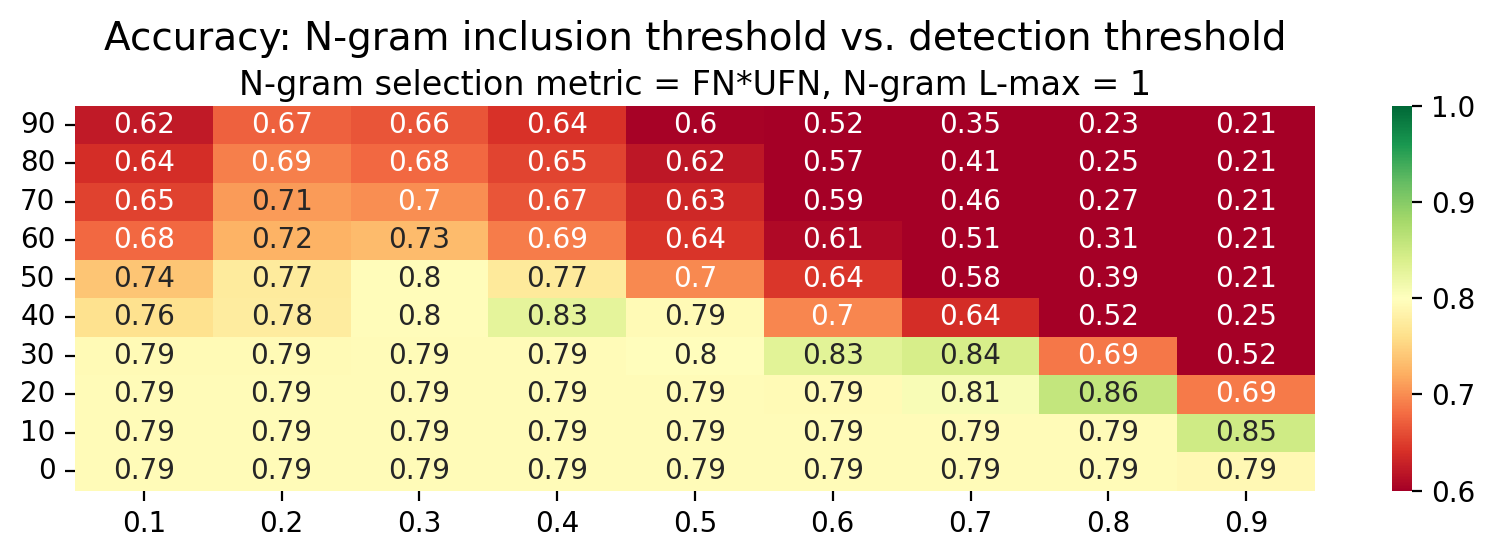

In [8]:
ngram_selection_metrics = ['TF-IDF','F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','CFR','FCR','MR','NLMI']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ngram_max_values = [1, 2, 3, 4]
ngram_inclusion_thresholds = [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]


# 1) N-gram selection metric - threshold
acc_analytics_threshold = np.zeros((len(ngram_selection_metrics), len(thresholds)))

for i, ngram_selection_metric in enumerate(ngram_selection_metrics):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any = analyse_dataset(ngram_selection_metric, 1, 20, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any = analyse_dataset(ngram_selection_metric, 1, 20, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any = analyse_dataset(ngram_selection_metric, 1, 20, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3
    for key in first_split_acc_any
    }

    for j, threshold in enumerate(thresholds):
        acc_analytics_threshold[i, j] = average_acc_data[threshold]

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="N-gram L-max = 1, inclusion threshold = 20%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)


# 2) ngram_max - threshold
acc_ngrammax_threshold = np.zeros((len(ngram_max_values), len(thresholds)))

for i, ngram_max in enumerate(ngram_max_values):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any = analyse_dataset('FN*UFN', ngram_max, 20, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any = analyse_dataset('FN*UFN', ngram_max, 20, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any = analyse_dataset('FN*UFN', ngram_max, 20, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3
    for key in first_split_acc_any
    }

    for j, threshold in enumerate(thresholds):
        acc_ngrammax_threshold[i, j] = average_acc_data[threshold]

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold, 1.0,
    title="Accuracy: N-gram L-max vs. detection threshold",
    subtitle="N-gram selection metric = FN*UFN, inclusion threshold = 20%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)


# 3) ngram_inclusion_threshold - threshold
acc_ngram_inclusion_threshold = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))

for i, ngram_inclusion_threshold in enumerate(ngram_inclusion_thresholds):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any = analyse_dataset('FN*UFN', 1, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any = analyse_dataset('FN*UFN', 1, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any = analyse_dataset('FN*UFN', 1, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3
    for key in first_split_acc_any
    }

    for j, threshold in enumerate(thresholds):
        acc_ngram_inclusion_threshold[i, j] = average_acc_data[threshold]

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="N-gram selection metric = FN*UFN, N-gram L-max = 1",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

In [10]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'1 day, 6:08:23.007413'

### Our best model obtained through the optimal combination of hyper-parameters

In [9]:
# Best model
part1 = df[df.index % 3 == 1]
part2 = df[df.index % 3 == 2]
part3 = df[df.index % 3 == 0]

splits = [
    (pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
    (pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
    (pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
]

for i, (train_df, test_df) in enumerate(splits, start=1):
    if i == 1:
        first_split_acc_any = analyse_dataset('FN*UFN', 1, 20, train_df, test_df, 'first_split', 'print_results')
    elif i == 2:
        second_split_acc_any = analyse_dataset('FN*UFN', 1, 20, train_df, test_df, 'second_split', 'print_results')
    elif i == 3:
        third_split_acc_any = analyse_dataset('FN*UFN', 1, 20, train_df, test_df, 'third_split', 'print_results')



N-gram selection metric: FN*UFN
N-gram max length: 1
N-gram inclusion threshold: 20
	FIRST COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7874172185430464 0.8810670618747685
		 0.2 0.7874172185430464 0.8810670618747685
		 0.3 0.7874172185430464 0.8810670618747685
		 0.4 0.7874172185430464 0.8810670618747685
		 0.5 0.7874172185430464 0.8810670618747685
		 0.6 0.7880794701986755 0.881305637982196
		 0.7 0.7966887417218543 0.8851477740366629
		 0.8 0.8695364238410596 0.9191629052113254
		 0.9 0.7086092715231788 0.7734294541709578

	SECOND COMBINATION
		Threshold, accuracy, F1 score:
		 0.1 0.7894039735099337 0.8823094004441155
		 0.2 0.7894039735099337 0.8823094004441155
		 0.3 0.7894039735099337 0.8823094004441155
		 0.4 0.7894039735099337 0.8823094004441155
		 0.5 0.7894039735099337 0.8823094004441155
		 0.6 0.7880794701986755 0.8814814814814815
		 0.7 0.7973509933774835 0.8852213053263316
		 0.8 0.8523178807947019 0.909312728751525
		 0.9 0.7245033112582782 0.7890466531440162

